In [1]:
import os 
import sys
import torch
import numpy as np
import pandas as pd
import transformers
import ujson as json
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '..')
from mntdmod import utils
from mntdmod import utilsnlp

r = 7
split = 'train'

## Check metadata

,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,...,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
0,id-00000000,True,2032452423,0,CyclicLR,1,0,NerLinear,0,0.00010,...,None,None,None,None,None,0.875497,0.930021,0.9884046381447421,0.9565646594274433,1
1,id-00000001,False,813358040,0,CyclicLR,0,0,NerLinear,0,0.00010,...,PERCENT,0.9149590163934426,0.8754901960784314,0.9149590163934426,0.8947895791583166,0.862154,0.915240,None,None,1
2,id-00000002,False,702283705,1,WarmupWithLinear,0,0,NerLinear,0,0.00010,...,None,None,None,None,None,0.904153,0.945218,None,None,1
3,id-00000003,True,2133254610,0,CyclicLR,1,0,NerLinear,1,0.00005,...,None,None,None,None,None,0.954247,0.961662,0.9607250755287009,0.9447852760736196,1
4,id-00000004,False,311840012,1,WarmupWithLinear,0,0,NerLinear,0,0.00010,...,None,None,None,None,None,0.865433,0.929659,None,None,1


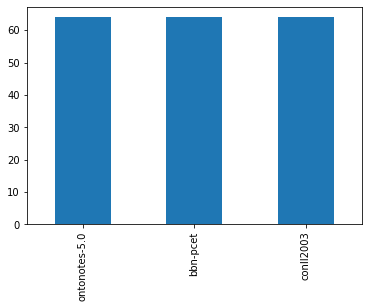

In [3]:
meta = utils.read_metafile()
meta['source_dataset'].value_counts().plot.bar()
meta.head()

### Check breakdown of models by class and underlying dataset/architecture 

In [4]:
meta.groupby(['poisoned']).size()

poisoned
False    96
True     96
dtype: int64

In [5]:
meta.groupby(['number_classes','source_dataset']).size()

number_classes  source_dataset
9               bbn-pcet          64
                conll2003         64
13              ontonotes-5.0     64
dtype: int64

In [6]:
meta.groupby(['source_dataset','poisoned']).size()

source_dataset  poisoned
bbn-pcet        False       32
                True        32
conll2003       False       32
                True        32
ontonotes-5.0   False       32
                True        32
dtype: int64

In [7]:
meta.groupby(['source_dataset', 'embedding', 'poisoned']).size()

source_dataset  embedding   poisoned
bbn-pcet        BERT        False       8
                            True        8
                DistilBERT  False       8
                            True        8
                MobileBERT  False       8
                            True        8
                RoBERTa     False       8
                            True        8
conll2003       BERT        False       8
                            True        8
                DistilBERT  False       8
                            True        8
                MobileBERT  False       8
                            True        8
                RoBERTa     False       8
                            True        8
ontonotes-5.0   BERT        False       8
                            True        8
                DistilBERT  False       8
                            True        8
                MobileBERT  False       8
                            True        8
                RoBERTa     False      

### Plot distribution of linear weights, clean vs. poisoned

In [8]:
def plot_clean_vs_poisoned_linear_weights_dist(clean_models, poisoned_models, title, legend=True):
    clean_weights = []
    for model_id in clean_models:
        model = utils.load_model(model_id)
        params = list(model.classifier.parameters())[0].cpu().detach().numpy().flatten()
        clean_weights.append(params)
    clean_weights = np.concatenate(clean_weights)
#     print(clean_weights.shape)

    df = pd.DataFrame()
    df['weights'] = clean_weights
    df['poisoned'] = False

    poisoned_weights = []
    for model_id in poisoned_models:
        model = utils.load_model(model_id)
        params = list(model.classifier.parameters())[0].cpu().detach().numpy().flatten()
        poisoned_weights.append(params)
    poisoned_weights = np.concatenate(poisoned_weights)
#     print(poisoned_weights.shape)
    
    assert clean_weights.shape == poisoned_weights.shape

    df2 = pd.DataFrame()
    df2['weights'] = poisoned_weights
    df2['poisoned'] = True

    df = df.append(df2)

    fig, axs = plt.subplots(1,1,figsize=(4,3))
    sns.histplot(data=df, x='weights', hue='poisoned', legend=legend, ax=axs)
    axs.set_title(title)
    sns.despine(fig, axs)
    
    plt.savefig(f'figs/{title}.jpg')    
    plt.show()

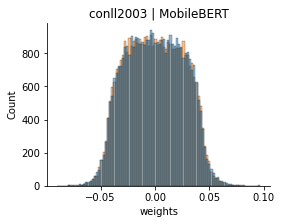

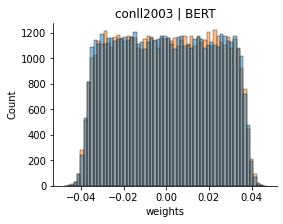

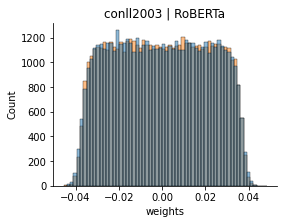

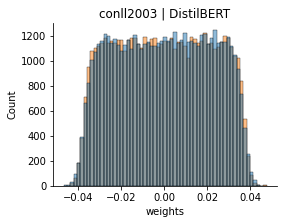

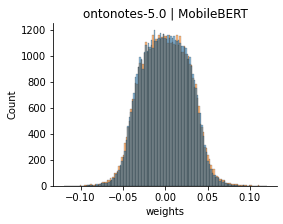

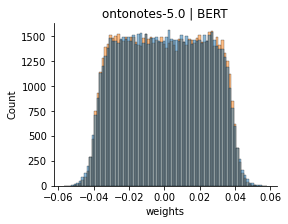

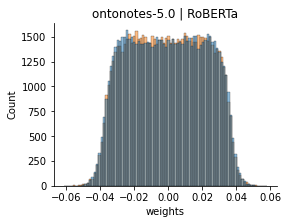

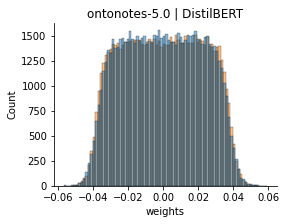

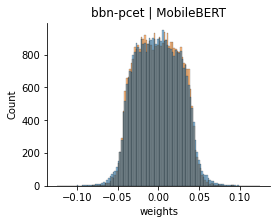

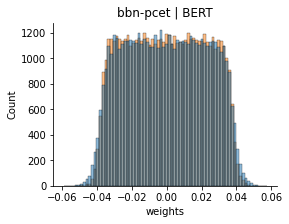

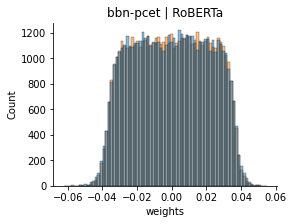

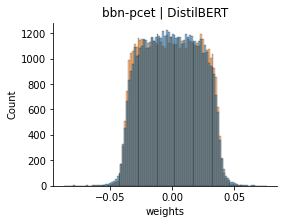

In [9]:
for dataset in meta['source_dataset'].unique():
    for embedding in meta['embedding'].unique():

        c, p = utils.get_clean_and_poisoned((
                ('source_dataset', dataset),
                ('embedding', embedding))
        )
        plot_clean_vs_poisoned_linear_weights_dist(c, p, f'{dataset} | {embedding}', legend=False)